***Automated workflow for Interpolating precipitation across the range!***
Nicole Kaplan, June 10, 2020

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages-and-establish-working-directory" data-toc-modified-id="Import-packages-and-establish-working-directory-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages and establish working directory</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Inverse-Distance-Weighting" data-toc-modified-id="Inverse-Distance-Weighting-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Inverse Distance Weighting</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Classification</a></span></li></ul></li><li><span><a href="#Get-Vector-Data-For-Points-and-Pastures" data-toc-modified-id="Get-Vector-Data-For-Points-and-Pastures-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get Vector Data For Points and Pastures</a></span></li><li><span><a href="#Get-Flagged-Precipitation-and-Soil-Moisture-Data" data-toc-modified-id="Get-Flagged-Precipitation-and-Soil-Moisture-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get Flagged Precipitation and Soil Moisture Data</a></span></li><li><span><a href="#Subset-and-resample-data" data-toc-modified-id="Subset-and-resample-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Subset and resample data</a></span><ul class="toc-item"><li><span><a href="#Convert-rainfall-to-inches" data-toc-modified-id="Convert-rainfall-to-inches-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Convert rainfall to inches</a></span></li></ul></li><li><span><a href="#Generate-np-Arrays-as-Input-into-IDW-Function" data-toc-modified-id="Generate-np-Arrays-as-Input-into-IDW-Function-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Generate np Arrays as Input into IDW Function</a></span><ul class="toc-item"><li><span><a href="#Frequency-of-rainfall-amounts" data-toc-modified-id="Frequency-of-rainfall-amounts-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Frequency of rainfall amounts</a></span></li><li><span><a href="#Check-on-the-order-of-pastures-within-in-each-array" data-toc-modified-id="Check-on-the-order-of-pastures-within-in-each-array-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Check on the order of pastures within in each array</a></span></li></ul></li><li><span><a href="#Run-IDW-and-Classification-Functions" data-toc-modified-id="Run-IDW-and-Classification-Functions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Run IDW and Classification Functions</a></span></li><li><span><a href="#Plot-PPT-IDW-Results" data-toc-modified-id="Plot-PPT-IDW-Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Plot PPT IDW Results</a></span></li></ul></div>

# Import packages and establish working directory

In [2]:
# Import Packages
#import warnings
#from glob import glob

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import rasterio as rio
import geopandas as gpd
from scipy.spatial import cKDTree
from datetime import datetime
import earthpy as et

from matplotlib.colors import ListedColormap
from matplotlib import colors
import earthpy.plot as ep
import rasterio as rio
from rasterio.plot import plotting_extent
import matplotlib.pyplot as plt

# Set seaborn plot style
sns.set_style("white")
sns.axes_style("white")
sns.set(font_scale=1.5)

#warnings.simplefilter('ignore')

In [3]:
# Set working directory
wd_path = os.path.join(et.io.HOME, 'ea_python_spatial', 'Final_Project', 'precip-interpolator', 'data')
#wd_path = os.path.join(et.io.HOME, 'Documents', 'earth-analytics', 'Final_Project', 'data')
if not os.path.exists(wd_path):
    os.mkdir(wd_path)    
    
os.chdir(wd_path)

# Create output folder
output_path = os.path.join("output_maps")

if not os.path.exists(output_path):
    os.mkdir(output_path)  


# Functions
## Inverse Distance Weighting

In [4]:
# Class containing functions for inverse distance weighing

"""
    Inverse distance weighting (IDW)
    --------------------------------

    Compute the score of query points based on the scores of their k-nearest neighbours,
    weighted by the inverse of their distances.

    @reference:
    https://en.wikipedia.org/wiki/Inverse_distance_weighting

    Arguments:
    ----------
        X: (N, d) ndarray
            Coordinates of N sample points in a d-dimensional space.
        z: (N,) ndarray
            Corresponding scores.
        leafsize: int (default 10)
            Leafsize of KD-tree data structure;
            should be less than 20.

    Returns:
    --------
        tree instance: object
        
    Notes:
    --------
    Wrapper around ___intit____().
    
   """


class tree(object):  # use tree as the name of the function
    def __init__(self, X=None, z=None, leafsize=10):
        if not X is None:
            self.tree = cKDTree(X, leafsize=leafsize)
        if not z is None:
            self.z = np.array(z)

    def fit(self, X=None, z=None, leafsize=10):

        return self.__init__(X, z, leafsize)

    def __call__(self, X, k=6, eps=1e-6, p=2, regularize_by=1e-9):

        self.distances, self.idx = self.tree.query(X, k, eps=eps, p=p)
        self.distances += regularize_by
        weights = self.z[self.idx.ravel()].reshape(self.idx.shape)
        mw = np.sum(weights/self.distances, axis=1) / \
            np.sum(1./self.distances, axis=1)

        return mw

    def transform(self, X, k=6, p=2, eps=1e-6, regularize_by=1e-9):
        return self.__call__(X, k, eps, p, regularize_by)

## Classification

In [5]:
def classify(to_class_arr, class_list):
    """
    Function classifies numpy arrays using classes defined

    Parameters
    ----------
    to_class_arr : numpy arr
        arrays that need to be classified

    Returns
    ------
    classified_arr : numpy arr
        arrays with classified values

    """
    # Calculate classes of precipitation amount
    class_bins = class_list
    classified_arr = np.digitize(to_class_arr, class_bins)

    return classified_arr

# Get Vector Data For Points and Pastures

In [6]:
# Get shape files and pasture boundaries
pasture_path = os.path.join("vector_data",
                            "CPER_Pastures_2014_AGM_TGM_pDOG.shp")
pasture_org = gpd.read_file(pasture_path)
carm_pastures = pasture_org[pasture_org['Treatment'].isin(["TGM", "AGM"])]
AGM_trt = pasture_org[pasture_org['Treatment'].isin(["AGM"])]

# Get shape files for site
cper_bndy_path = os.path.join("vector_data", "CPERBody.shp")
cper_bndy = gpd.read_file(cper_bndy_path)
cper_bounds = cper_bndy.bounds

# Get locations for ppt gauges
ppt_xy_path = os.path.join("abiotic_data", "ppt_locations.csv")
ppt_xy = pd.read_csv(ppt_xy_path)
ppt_xy_sort = ppt_xy.sort_values(by=['pasture'], ascending=True)

extent = (527273.75, 517624.84375, 4514740.5, 4524361.0)


# Get Flagged Precipitation and Soil Moisture Data

In [7]:
# read in abiotic data as dataframes
flagged_data_path = os.path.join('abiotic_data') #, 'HydroMet', 'flagged_input')
flagged_data_list = ["flagged_ppt.csv"] #, "flagged_wc.csv"]
df_list = []

for i in flagged_data_list:
    path = os.path.join(flagged_data_path, i)
    #print(os.path.exists(path))
    df = pd.read_csv(path, parse_dates=['date'], delimiter = ",", usecols = (5,6,8,10,11,12))
    df.rename(columns={'raw.value': 'raw_value', 'raw.measurement' : 'raw_measurement'}, inplace=True)
    df_list += [df]

df_ppt = df_list[0]

df_ppt['date'] = pd.to_datetime( df_ppt['date'], format='%Y-%m-%d')
#df_wc = df_list[1]      

# Subset and resample data 

In [8]:
# use function to generate cumulative rainfall for period of time from last data download
# figure out number of weeks back from last day in dataframe

# get last date in the dataset
date2 = (df_ppt['date'].max()) #USE DATE2 FOR PLOTTING!!!!
date1 = date2 - pd.offsets.Day(21)

# filter for range 
df_ppt_range = df_ppt.loc[(
    df_ppt['date'] > date1) & (df_ppt['date'] < date2)]
df_ppt_range = df_ppt.sort_values(by=['site'], ascending=True)

#merge dataframe and cumulative sum for each site
df_merged = pd.merge(df_ppt_range, ppt_xy[["pasture", "Easting_UTM", "Northing_UTM"]], 
                     left_on="site", right_on="pasture", how="left")

#df_ppt_wks2 = df_merged.groupby(["site", "Easting_UTM", "Northing_UTM"])['raw_value'].sum().groupby(level='site').cumsum() 

df_ppt_wks = df_merged.groupby(["site"])['raw_value'].sum()
df_xy = df_merged.groupby(["site"]).first()
df_xy = df_xy[["Easting_UTM", "Northing_UTM"]]

## Convert rainfall to inches

In [9]:
# Convert pandas column in dataframe from mm ot inches
df_ppt_wks = df_ppt_wks / 25.4

# Generate np Arrays as Input into IDW Function

In [10]:
# Convert data to numpy array
ar_ppt_wks = df_ppt_wks.to_numpy()
ppt_xy_list = df_xy.to_numpy()


## Frequency of rainfall amounts

[Text(0, 0.5, 'number of occurences'),
 Text(0.5, 0, '21 day rain total (in)'),
 Text(0.5, 1.0, ' Rainfall for the last 3 weeks on the CPER from 2020-05-19 00:00:00 to 2020-06-09 00:00:00')]

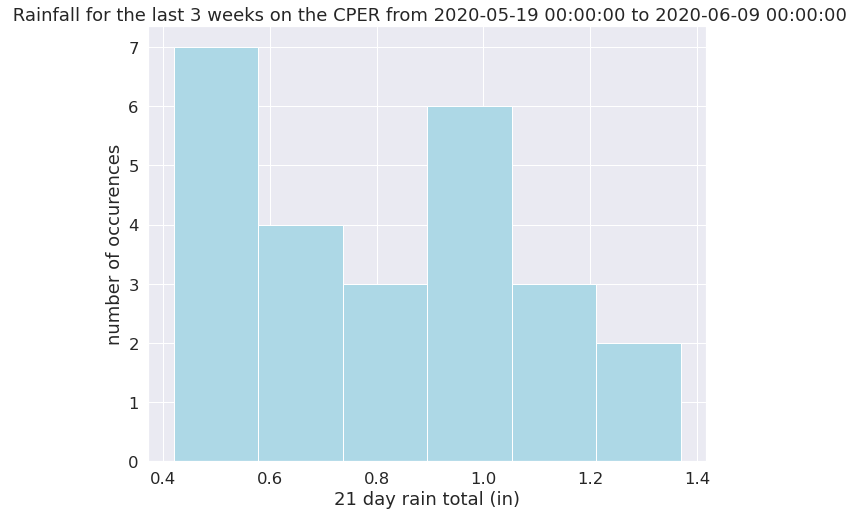

In [19]:
# Histogram of 21 day rainfall 
fig, (ax) = plt.subplots(figsize=(10,8))
df_ppt_wks.hist(ax=ax,  bins=6, color="lightblue")
ax.set(xlabel="21 day rain total (in)",
        ylabel="number of occurences", 
        title=" Rainfall for the last 3 weeks on the CPER from "  +str(date1)+ " to " +str(date2))

## Check on the order of pastures within in each array

# Run IDW and Classification Functions

In [13]:
# Create grid from CPER boundary
spacing_x = np.linspace(517624.84375, 527273.75, 40)
spacing_y = np.linspace(4514740.5, 4524361.0, 40)
X2 = np.meshgrid(spacing_x, spacing_y)
X2 = np.reshape(X2, (2, -1)).T

In [14]:
# Assign data to be interpolated for one date
X = np.reshape(ppt_xy_list, (2, -1)).T  # site points as array

In [15]:
# Run function and return list of interpolated dataframes for seasonal precipitation
season_list_ppt = [.1, .2, .4, .6, .8, 1, 1.2, np.inf]
z = np.array(df_ppt_wks)  # values as array
model = tree(X, z)
model.fit()
results = model.transform(X2)
ppt_season_class = classify(results, season_list_ppt)
idw = np.column_stack((results, X2, ppt_season_class))

## Plot IDW instead of idw_df_season
idw_df_season = gpd.GeoDataFrame(idw, geometry=gpd.points_from_xy(idw[:, 1], idw[:, 2]))
  

# Plot PPT IDW Results

In [16]:
# Colors for mapping interpolated time-series 2 weeks rainfall
colors = ["mintcream", "aquamarine", "greenyellow", "lightgreen",
          "yellowgreen", "seagreen", "forestgreen", "darkgreen"]
cmap = ListedColormap(colors)
classes = [1, 2, 3, 4, 5, 6, 7, 8]
class_names = {1: "no rain", 2: "10mm",
               3: "20mm", 4: "30mm", 5: "40mm", 6: "50mm", 7: "60mm", 8: ">70mm"}
class_dict = {1: "mintcream", 2: "aquamarine", 3: "greenyellow", 4: "lightgreen", 5: "yellowgreen",
              6: "seagreen", 7: "forestgreen", 8: "darkgreen"}

# Production data
prod_class_dict = {1: "lightyellow", 2: "peachpuff",
                   3: "coral", 4: "tomato", 5: "dakred", 6: "fuchsia"}
prod_colors = ["lightyellow", "peachpuff",
               "coral", "tomato", "darkred", "fuchsia"]
prod_cmap = ListedColormap(prod_colors)

# Seasonal total
season_colors = ["powderblue", "lightblue", "skyblue",
                 "cornflowerblue", "steelblue", "darkblue", "indigo"]
season_cmap = ListedColormap(season_colors)

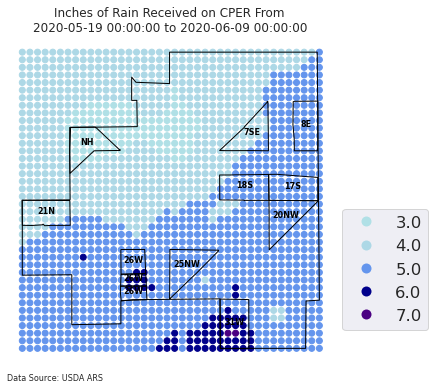

In [17]:
# Plot interpolation of seasonal precipitation

fig, ax = plt.subplots(figsize=(6,6))

idw_df_season.plot(column=idw_df_season[3],
                   categorical=True,
                   legend=True,
                   cmap=season_cmap,
                   ax=ax)
cper_bndy.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)
ax2 = AGM_trt.plot(alpha=1, ax=ax, color="none", edgecolor="black", linewidth=1)
AGM_trt.apply(lambda x: ax2.annotate(s=x.Past_Name_, xy=x.geometry.centroid.coords[0], 
                                     ha='center', fontsize=8, color="black", fontweight='bold'),axis=1)
ax.set_title("Inches of Rain Received on CPER From \n" +str(date1)+ " to " +str(date2), fontsize=12)

ax.text(0, -.05, 'Data Source: USDA ARS', transform=ax.transAxes, fontsize=8)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.5))
ax.set_axis_off()

filepath = os.path.join(output_path, 'seasonal_ppt.jpg')
plt.savefig(filepath, dpi=300)

In [ ]:
##COPIED FROM TEXTBOOK for plotting with nparrays (object=idw)
values_ppt = np.unique(idw[:, 3]).tolist() #issue is shape is (1600, ), so no grid for plotting

# Add another index value because for n categories
# you need n+1 values to create bins
#values = [0] + values

ppt_cat_names = ["1inch", "2inch", "3inch"]

ppt_colors = [ "lightblue", "skyblue",
                 "cornflowerblue"]
ppt_cmap = ListedColormap(ppt_colors)

In [ ]:
## COPIED FROM TEXTBOOK with earth py
# Plot the data with a custom legend
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(idw[:, 3],
               cmap=ppt_cmap)
               #extent=extent)


#values = np.unique(dnbr_landsat_class.ravel())

ep.draw_legend(im,
               classes=values_ppt,
               titles=ppt_cat_names)

ax.set_title("title here",
             fontsize=16)

# turn off ticks
ax.set_axis_off()
plt.show()